# Amazon has a lot of products and categories, therefore our goal is to predict a best seller item by it's features. 

# Data Acquisition

To start collecting the data we will try to get as much data possible from amazon's best sellers page sorted by categories.
https://www.amazon.com/Best-Sellers/zgbs

The main problem is that each page for category in this url gives only 100 top best sellers per category, we should be able to collect also non-bestsellers so the idea is:
1. To get the categories names using bs4 from the link above ^.
2. Generate a template of a simple search url for each category name (this way we include also non-bestsellers).
3. Using Selenium we iterate all pages per category and collect all item links in page. Storing link to each item in a text file itemsUrls.txt.
4. Reading the itemsUrls.txt iterate each link and by using selenium collecting all the features we can.
5. After getting all features in lists we are creating a data frame and exporting it to csv file named 'Amazon Items Scraped.csv'.

Starting with getting the products categories from amazon, making a template url to run on each category.

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import csv

from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.by import By
import time


URL = 'https://www.amazon.com/Best-Sellers/zgbs'
header = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.63 Safari/537.36','referer': 'https://www.amazon.com/'}
html = requests.get(URL, headers=header)
soup = BeautifulSoup(html.content, 'html.parser')
category = soup("div", attrs={
                'class': '_p13n-zg-nav-tree-all_style_zg-browse-item__1rdKf _p13n-zg-nav-tree-all_style_zg-browse-height-small__nleKL'})


categoryNames = list()


#categoryURL = list()

for name in category:
    categoryNames.append(name.get_text())


# -----------------------------------------------------------------------------------------------------------------------------------------

# template = "https://www.amazon.com/s?k={q}&crid=SQLSKT8LVCGV&sprefix=%2Caps%2C254&ref=nb_sb_ss_recent_1_0_recent"
template = "https://www.amazon.com/s?k={q}&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1"

searchTerms = list()

for i in categoryNames:
    i = i.replace('&', '')
    searchTerms.append(i)



SearchLinks = list()
for i in searchTerms: #we are getting blocked for to many requests so we did it in 2 steps [:29] - [29:]
    SearchLinks.append(template.format(q=i))

for i in SearchLinks:
    print(i)




https://www.amazon.com/s?k=Amazon Devices  Accessories&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Amazon Launchpad&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Appliances&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Apps  Games&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Arts, Crafts  Sewing&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Audible Books  Originals&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Automotive&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Baby&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Beauty  Personal Care&crid=38FTQ2MB4WEA&sprefix=laptop%2Caps%2C323&ref=nb_sb_noss_1
https://www.amazon.com/s?k=Books&crid=38FTQ2MB4

From now on we are going to use Selenium to extract our data due to blockings we've got trying to pull all data at once.

Starting with writing a few helpful functions to extract the actual text for features from a web object that is returned by the find_elements Selenium's method.

In [ ]:
#selenium web object extraction get text

def getNextPageUrl(nextPageTag):#TAG
    for i in range(0, len(nextPageTag)):
        return nextPageTag[i].get_attribute('href')

def getItemText(obj):
    for i in range(0, len(obj)):
        return obj[i].text


def getItemLink(obj):
    for i in range(0, len(obj)):
        return obj[i].get_attribute('href')

After we got the urls for each category we iterate the pages in each category and collecting the url for each product.

In [ ]:

#opens a webdriver 
driver = webdriver.Chrome(ChromeDriverManager().install())

# used for getting items' urls in each category link (SearchLinks) from previous stage
itemsLinks = list()

for link in SearchLinks:
    driver.get(link)
    time.sleep(2)
    
    #link tag of each item
    LinkTag = driver.find_elements_by_xpath("//a[contains(@class, 'a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal')]")
    # itemsLinks.append(getItemLink(LinkTag))
    for i in range(0, len(LinkTag)):
        itemsLinks.append(LinkTag[i].get_attribute('href'))

    # get next page url
    nextPageTag = driver.find_elements_by_xpath("//a[contains(@class, 's-pagination-next')]")
    while nextPageTag:
        nextPageUrl = getNextPageUrl(nextPageTag)
        driver.get(nextPageUrl)
        time.sleep(2)
        nextPageTag = driver.find_elements_by_xpath("//a[contains(@class, 's-pagination-next')]")
        LinkTag = driver.find_elements_by_xpath("//a[contains(@class, 'a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal')]")
        # itemsLinks.append(getItemLink(LinkTag))
        for i in range(0, len(LinkTag)):
            itemsLinks.append(LinkTag[i].get_attribute('href'))



Writing each item link to a file itemsUrls.txt.

In [ ]:

#writes the items urls to file_name.txt
with open('itemsUrls.txt', 'w') as f:
    for i in itemsLinks:
            # write each item on a new line
        f.write("%s\n" % i)
    print('Done copying urls to a file')

Done copying urls to a file
Total links after removing duplicates 3972


Now let's remove duplicates in itemsUrls.txt and start pulling our data foreach product.

In [ ]:
#removing duplicates
itemsLinks = list(dict.fromkeys(itemsLinks))
# print(len(list(dict.fromkeys(itemsLinks))))
print('Total links after removing duplicates ' + str(len(itemsLinks)))


Opening the itemsUrls.txt file and collecting the features for each item url in file.

In [ ]:
# from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
# import requests
import csv
import warnings
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
warnings.filterwarnings('ignore')

#go to each item in itemsUrls file and get it's fields , inserting to lists and making a dataframe

driver = webdriver.Chrome(ChromeDriverManager().install())
#opens the url file
with open("itemsUrls.txt") as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

# lines = itemsLinks

Name = list()
Brand = list()  # a id=bylineInfo
Rating = list()  # span id="acrCustomerReviewText" /
Comments = list()  # a id=askATFLink > span class="a-size-base"
#AnswersAmount = list() #
# <i class="a-icon a-icon-addon p13n-best-seller-badge">#1 Best Seller</i>
BestSeller = list()
Price = list()  # has to be from last stage
# iCategory = list()  # span class="ac-keyword-link"
#IsFreeShipping = list()  #
Discount = list()  # div class="a-section a-spacing-medium tradein-price-block"
AmazonChoice = list()  # span class="ac-badge-text-primary ac-white"
Stars = list()  # span id=acrPopover

filename = 'items.csv'
#run for each item's url and collect the data

for line in lines[1255:]:#for line in lines[-10700:-5000]:
    driver.get(line)
    
    iNames = driver.find_elements_by_xpath("//span[contains(@id, 'productTitle')]") 
    if iNames:
        Name.append(getItemText(iNames))
    else:
        iNames = 'NaN'
        Name.append(iNames)

    iBrand = driver.find_elements_by_xpath("//a[contains(@id, 'bylineInfo')]")
    if iBrand:
        Brand.append(getItemText(iBrand))
    else:
        iBrand = 'NaN'
        Brand.append(iBrand)

    iRating = driver.find_elements_by_xpath("//span[contains(@id, 'acrCustomerReviewText')]")
    if iRating:
        Rating.append(getItemText(iRating))
    else:
        iRating = 'NaN'
        Rating.append(iRating)

    iBestSeller = driver.find_elements_by_xpath("//i[contains(@class, 'a-icon a-icon-addon p13n-best-seller-badge')]")
    if iBestSeller:
        BestSeller.append(1)
    else:
        
        BestSeller.append(0)

    iAmazonChoice = driver.find_elements_by_xpath("//span[contains(@class, 'ac-badge-text-primary ac-white')]")
    if iAmazonChoice:
        AmazonChoice.append(1)
    else:
        AmazonChoice.append(0)

    iComments = driver.find_elements_by_xpath("//a[contains(@id, 'askATFLink')]")
    if iComments:
        Comments.append(getItemText(iComments))
    else:
        iComments = 'NaN'
        Comments.append(iComments)

    iPrice = driver.find_elements_by_xpath("//span[contains(@class, 'a-price a-text-price a-size-medium apexPriceToPay')]")
    if iPrice:
        Price.append(getItemText(iPrice))
    else:
        Price.append('NaN')

    iStars = driver.find_elements_by_xpath("//span[contains(@class, 'a-size-medium a-color-base')]")
    if iStars:
        Stars.append(getItemText(iStars))
    else:
        iStars = 'NaN'
        Stars.append(iStars)

Some checkings after pulling the features for items and exporting our new dataframe to a csv file.

In [ ]:
print(len(Name))
print(len(Brand))
print(len(Rating))
print(len(BestSeller))
print(len(AmazonChoice))
print(len(Comments))
print(len(Price))
print(len(Stars))

7120
7120
7120
7120
7120
7120
7120
7120


In [ ]:
rows = list()

df = pd.DataFrame({'Name': Name, 'Brand': Brand, 'Rating': Rating, 'BestSeller': BestSeller,
                  'AmazonChoice': AmazonChoice, 'Comments': Comments, 'Price': Price, 'Stars': Stars})

df.to_csv('Amazon Items Scraped.csv', index=False)

In [ ]:
# for i in rows:
#     print(i)

# with open('2380_dataFrame_new.csv', 'w') as f:
#     # f.write(Details)
#     for i in rows:
#         f.write(i)

# Data Handling

Loading the dataset from the csv, removing duplicates and corrupted values.

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import csv

df = pd.read_csv("Amazon Items Scraped.csv")
print('Shape before cleaning: ' + str(df.shape))

# Remove Corrupted Rows ---------------------------------------------------------------------
df = df.dropna(axis = 0, thresh=8)
print('Shape after removing corrupted: ' + str(df.shape))

# Drop Duplicates --------------------------------------------------------------------------
df = df.drop_duplicates(subset = None, keep = 'first')
print('Shape after removing duplicates: ' + str(df.shape))


Shape before cleaning: (13134, 8)
Shape after removing corrupted: (5230, 8)
Shape after removing duplicates: (5116, 8)


Cleaning and normalizing the data

The data we've got has non-informational data so we have to clean each feature to fit our needs. (For example: for the 'Price' field we have to remove the $).

In [ ]:
# Function - Delete char in string ---------------------------------------------------------

def deleteCharInString(df, c) :
    ilist = list()
    for i in df :
        ilist.append(i.replace(c, ''))
    df = ilist
    return df

In [ ]:
# Cleaning the Brand name ------------------------------------------------------------------

df.Brand = deleteCharInString(df.Brand, "Brand:")
df.Brand = deleteCharInString(df.Brand, "Visit the ")
df.Brand = deleteCharInString(df.Brand, " Store")

iBrand = list()
for i in df.Brand :
    if i == "0" :
        iBrand.append(np.nan)
    else :
        iBrand.append(i)

df.Brand = iBrand
df = df.dropna(axis = 0, thresh=8)

print(df.Brand)

0                 Amazon
4          Amazon Basics
5                 Amazon
7                 Amazon
8                 EDIVIA
              ...       
12972     American Eagle
12991             Amazon
13002             Amazon
13031             Amazon
13117          Frito-Lay
Name: Brand, Length: 3454, dtype: object


In [ ]:
# Cleaning the Ratings ------------------------------------------------------------------

df.Rating = deleteCharInString(df.Rating, " ratings")
df.Rating = deleteCharInString(df.Rating, " rating")
df.Rating = deleteCharInString(df.Rating, ",")
df["Rating"] = df.Rating.astype(float)
print(df.Rating)

0         64803.0
4          7851.0
5        145478.0
7        117007.0
8            82.0
           ...   
12972      5999.0
12991      3950.0
13002      7520.0
13031      3014.0
13117     17706.0
Name: Rating, Length: 3454, dtype: float64


In [ ]:
# Cleaning the Stars ------------------------------------------------------------------

df.Stars = deleteCharInString(df.Stars, " out of 5")

ilist = list()
for i in df.Stars :
    ilist.append(i.replace("How confident are you in finding a size that will fit you well?", '0'))
df.Stars = ilist
ilist = list()
for i in df.Stars :
    ilist.append(i.replace("|", '0'))
df.Stars = ilist
ilist = list()
for i in df.Stars :
    ilist.append(i.replace("confirmed", '0'))
df.Stars = ilist
ilist = list()
for i in df.Stars :
    ilist.append(i.replace("4,8 von 5", '4.8'))
df.Stars = ilist

df["Stars"] = df.Stars.astype(float)
df.loc[df['Stars'] == 0, 'Stars'] = np.nan


df.Stars



0        4.5
4        4.6
5        4.0
7        4.7
8        4.3
        ... 
12972    4.9
12991    4.9
13002    4.9
13031    4.9
13117    4.6
Name: Stars, Length: 3454, dtype: float64

In [ ]:
# Cleaning the Price ------------------------------------------------------------------

df.Price = deleteCharInString(df.Price, "$")
df.Price = deleteCharInString(df.Price, ",")

iPrice = list()

for i in df.Price :
    if i == "0" :
        iPrice.append(np.nan)
    else :
        iPrice.append(i)

df.Price = iPrice
df = df.dropna(axis = 0, thresh=8)
df["Price"] = df.Price.astype(float)
print(df.Price)

8         16.99
10        13.95
12        29.88
16        30.40
17        14.44
          ...  
12972     25.00
12991    100.00
13002     10.00
13031     30.00
13117     28.00
Name: Price, Length: 2706, dtype: float64


In [ ]:
# Cleaning the Comments ------------------------------------------------------------------

df.Comments = deleteCharInString(df.Comments, "+")
df.Comments = deleteCharInString(df.Comments, " answered questions")
df["Comments"] = df.Comments.astype(float)
df.loc[df['Comments'] == 0, 'Comments'] = np.nan
print(df.Comments)


8           NaN
10         28.0
12       1000.0
16          NaN
17        277.0
          ...  
12972       4.0
12991      15.0
13002      12.0
13031       3.0
13117      33.0
Name: Comments, Length: 2706, dtype: float64


Creating a cleaned csv file 'Amazon Items Cleaned.csv'

In [ ]:
# Reset DataFrame Index and delete NaN rows ---------------------------------------------------------------

df = df.dropna(axis = 0, thresh=8)
df = df.reset_index(drop=True)

df.to_csv("Amazon Items Cleaned.csv", index = None)
df.shape

(1636, 8)

# Exploratory Data Analysis

In this section we will get familiar with our extracted cleaned data and try to visualize some useful information.

Starting with using shape to get rows cols length and looking at the actual data frame.

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import csv
import seaborn as sns


df = pd.read_csv("Amazon Items Cleaned.csv" )
print(df.shape)
df

(1636, 8)


,Name,Brand,Rating,BestSeller,AmazonChoice,Comments,Price,Stars
0,"NOCO NUSB211NA 10W USB Power Adapter, 2.1A 5V ...",NOCO,3869.0,0,0,28.0,13.95,4.7
1,Amazfit Band 5 Activity Fitness Tracker with A...,Amazfit,21158.0,0,0,1000.0,29.88,4.1
2,Amazon Basics Universal Travel Case Organizer ...,AmazonBasics,16242.0,0,1,277.0,14.44,4.6
3,"Amazon Glow with Tangram Bits | Learn, Play, R...",Amazon,215.0,0,1,31.0,329.98,4.4
4,"Echo Show 5 (2nd Gen, 2021 release) - Deep Sea...",Amazon,928.0,0,1,21.0,114.98,4.7
...,...,...,...,...,...,...,...,...
1631,American Eagle Gift Card,American Eagle,5999.0,0,0,4.0,25.00,4.9
1632,Amazon.com Gift Cards - As a Bookmark,Amazon,3950.0,0,0,15.0,100.00,4.9
1633,Amazon.com Gift Card in a Gift Tag,Amazon,7520.0,0,0,12.0,10.00,4.9
1634,"Amazon.com $10 Gift Cards, Pack of 3 (Holiday ...",Amazon,3014.0,0,0,3.0,30.00,4.9


First look on the data, using info we can tell the type for each feature.

In [6]:
# Non null means our data is full without missing data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1605 non-null   object 
 1   Brand         1605 non-null   object 
 2   Rating        1605 non-null   float64
 3   BestSeller    1605 non-null   int64  
 4   AmazonChoice  1605 non-null   int64  
 5   Comments      1605 non-null   float64
 6   Price         1605 non-null   float64
 7   Stars         1605 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 100.4+ KB


Checking data after cleaning using describe can give you useful information about unique values, means frequent values and so on.

In [5]:
df.describe(include='all')

,Name,Brand,Rating,BestSeller,AmazonChoice,Comments,Price,Stars
count,1636,1636,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000
unique,1442,789,NaN,NaN,NaN,NaN,NaN,NaN
top,The Franklin Mint Founding Fathers Coin Collec...,Amazon,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,71,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,7168.836797,0.028117,0.267726,73.822738,84.398833,4.468521
std,NaN,NaN,25972.522900,0.165359,0.442909,164.568799,211.353176,0.308997
min,NaN,NaN,1.000000,0.000000,0.000000,3.000000,2.120000,1.000000
25%,NaN,NaN,94.750000,0.000000,0.000000,7.000000,14.997500,4.300000
50%,NaN,NaN,624.000000,0.000000,0.000000,19.000000,26.980000,4.500000
75%,NaN,NaN,3637.250000,0.000000,1.000000,57.250000,59.952500,4.700000


Back to our research question, let's focus on the bestseller field and generate a frequency table for best seller items.

   BestSeller  Frequency          p
0           0       1590  97.188264
1           1         46   2.811736


<AxesSubplot:ylabel='BestSeller'>

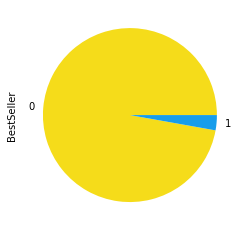

In [6]:
# Show the Frequency of the Best Sellers items with PIE visualization -------------------------------------------------------------------------------

counts = df["BestSeller"].value_counts()
p = df["BestSeller"].value_counts(normalize = True) * 100
index = [0,1]
FrequencyDF = pd.DataFrame({"BestSeller" : index,"Frequency": counts, "p" : p})
print(FrequencyDF)

myColors = ['#F5DC1A', '#179deb']
df['BestSeller'].value_counts().plot(kind = 'pie', colors = myColors)

As you can see about 2.8% are best sellers.

Checking for outliers on price with an histogram

Text(0, 0.5, 'Amount')

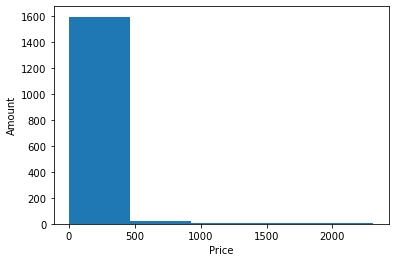

In [7]:
# We can see that most of the items in amazon are falling under the first section in the histogram price < 500 ------------------------------------------------

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(df.Price, bins = 5)
plt.xlabel("Price")
plt.ylabel("Amount")

Let's check if the items above 700 USD are Best Selleers

In [8]:
print(sum(df.Price > 700))


31


Let's use a boxplot to visualize outliers values for price.

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

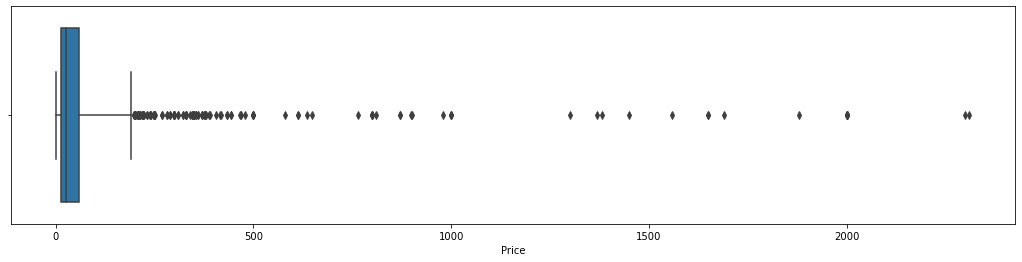

In [9]:
fig = plt.figure(figsize=(18,4))
sns.boxplot(df.Price, whis=3)

In [12]:
#('Outliers that are also a bestsellers'+ str(sum(df.Price > 700 and df.BestSeller == 1)))

Checking the outliers with IQR variable

In [13]:
Q1 = np.percentile(df["Price"], 25)
Q3 = np.percentile(df["Price"], 75)
IQR = Q3 - Q1

fareOutlierRows = df[(df["Price"] < Q1 - 1.5 * IQR) | (df["Price"] > Q3 + 1.5 * IQR )].index

print("The amount of outliers by IQR : " + str(len(fareOutlierRows)))

z_price = (df['Price'] - df['Price'].mean()) / df['Price'].std()
outliers = abs(z_price) > 3
print("We found that there are " + str(sum(outliers)) + " items above 700 USD")

min(df.Price[outliers])
df.Price[df.Price > 700] = np.nan
df = df.dropna(axis=0, thresh=8)
df["Price"].describe()

df.to_csv("Amazon Items Cleaned.csv", index=None)


The amount of outliers by IQR : 232
We found that there are 52 items above 700 USD


C:\Users\Yaniv\AppData\Local\Temp/ipykernel_23792/461335230.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Price[df.Price > 700] = np.nan


It is clear that we don't need the 52 outliers that are above 700 also because non of them is a best seller.

After droping all prices outliers we can see the new boxplot which looks much better now.

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

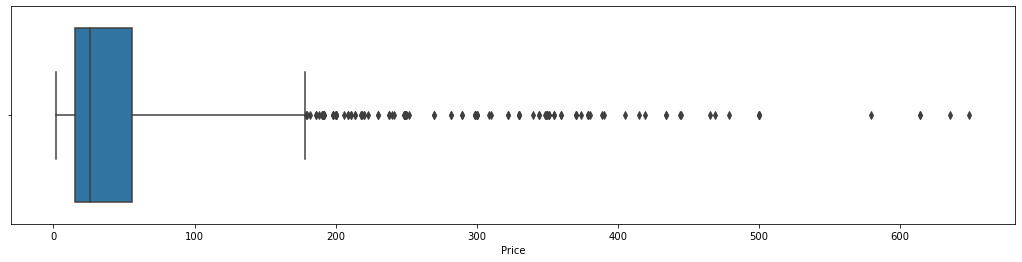

In [14]:
fig = plt.figure(figsize=(18,4))
sns.boxplot(df.Price, whis=3)

Checking for some correlation on Price and Comments values.

Text(0, 0.5, 'Comments')

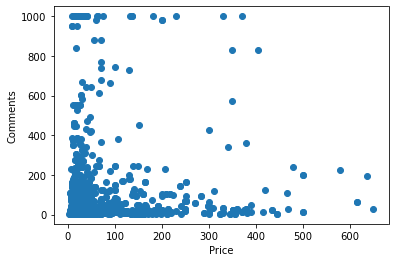

In [15]:
plt.scatter(df.Price, df.Comments)
plt.xlabel("Price")
plt.ylabel("Comments")


We don't see any linear pattern between prices and amount of comments on an item but we can see that items with price > 400 usd has less amount of comments generally.

Scaterring - Best Seller and Rating values

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BestSeller', ylabel='Rating'>

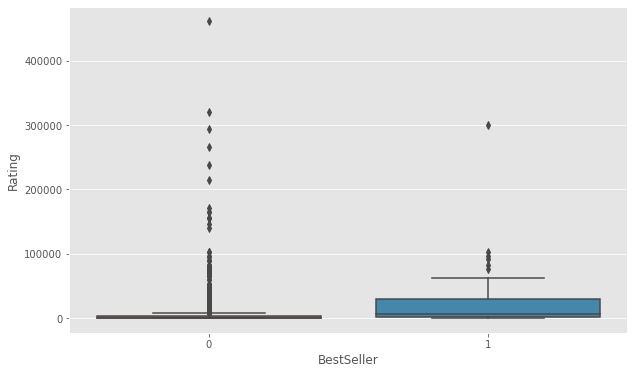

In [114]:
sns.boxplot(df.BestSeller, df.Rating)

Here we can see that the amount of ratings not always indicates if an item is a best seller or not.

Same thing on comments versus best seller.

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BestSeller', ylabel='Comments'>

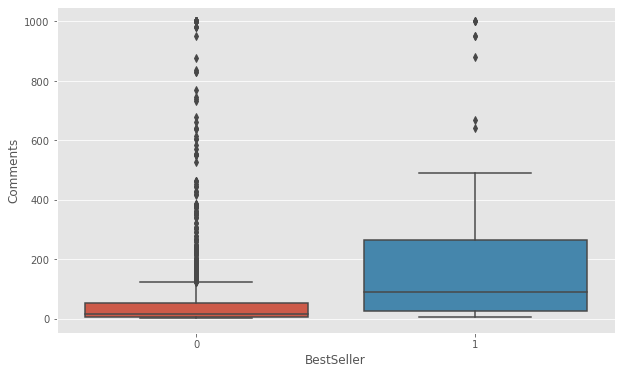

In [116]:
sns.boxplot(df.BestSeller, df.Comments)

We can see that the majority of bestsellers are with 0-300 comments, that indicates that comment alone is not a good indicator for finding bestseller among the items.

Price / Bestseller

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BestSeller', ylabel='Price'>

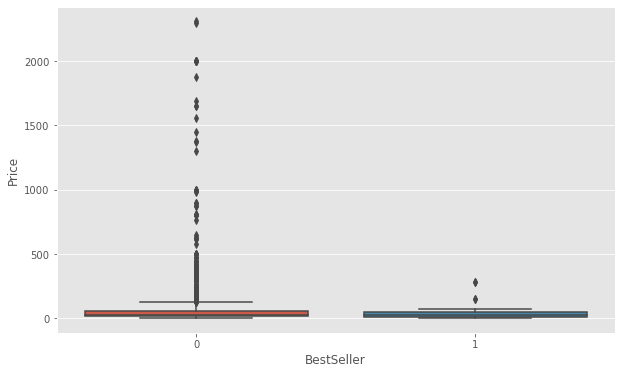

In [115]:
sns.boxplot(df.BestSeller, df.Price)


The majority are with price 0-100$

Let's try same thing with Stars - Best Seller -> Stars

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BestSeller', ylabel='Stars'>

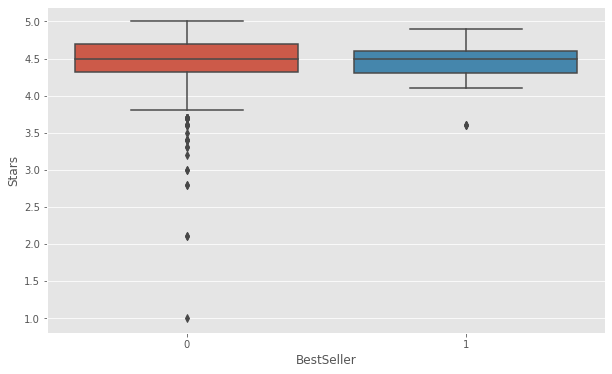

In [117]:
sns.boxplot(df.BestSeller, df.Stars)


Another way to look is using cross tabulation.

In [20]:
ct1 = pd.crosstab(df["Stars"], df["BestSeller"])
ct1

BestSeller,0,1
Stars,,
1.0,1,0
2.1,2,0
2.8,2,0
3.0,2,0
3.2,1,0
3.3,2,0
3.4,5,0
3.5,1,0
3.6,8,3


We can see that majority Best Seller items must have above 4.0 stars

Let's make a plot.

Text(0, 0.5, 'Best Seller')

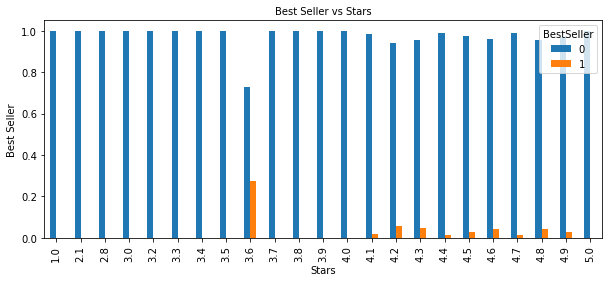

In [21]:
ct2 = pd.crosstab(df["Stars"], df["BestSeller"], normalize="index")
ct2.plot(kind = 'bar', figsize = (10,4))
plt.title('Best Seller vs Stars', fontsize = 10)
plt.xlabel('Stars')
plt.ylabel('Best Seller')

We found that there is some correlation, the majority of bestseller items has above 4.0 Stars 

Let's check our base assumption with the - Chi Test -

H0 = There is no correlation between Best Seller and Stars

In [22]:
from scipy.stats import chi2_contingency
chi2_contingency(ct1)

(38.90817150084312,
 0.014457635946154766,
 22,
 array([[9.71339564e-01, 2.86604361e-02],
        [1.94267913e+00, 5.73208723e-02],
        [1.94267913e+00, 5.73208723e-02],
        [1.94267913e+00, 5.73208723e-02],
        [9.71339564e-01, 2.86604361e-02],
        [1.94267913e+00, 5.73208723e-02],
        [4.85669782e+00, 1.43302181e-01],
        [9.71339564e-01, 2.86604361e-02],
        [1.06847352e+01, 3.15264798e-01],
        [1.55414330e+01, 4.58566978e-01],
        [9.71339564e+00, 2.86604361e-01],
        [2.81688474e+01, 8.31152648e-01],
        [4.85669782e+01, 1.43302181e+00],
        [5.92517134e+01, 1.74828660e+00],
        [8.25638629e+01, 2.43613707e+00],
        [1.24331464e+02, 3.66853583e+00],
        [2.29236137e+02, 6.76386293e+00],
        [2.59347664e+02, 7.65233645e+00],
        [2.39920872e+02, 7.07912773e+00],
        [2.31178816e+02, 6.82118380e+00],
        [1.31130841e+02, 3.86915888e+00],
        [6.41084112e+01, 1.89158879e+00],
        [9.71339564e+00, 2.8

P value < 0.05 therefore H0 is wrong and we do have a connection between Best Seller and Stars and we pick the H1

<AxesSubplot:xlabel='Price', ylabel='Stars'>

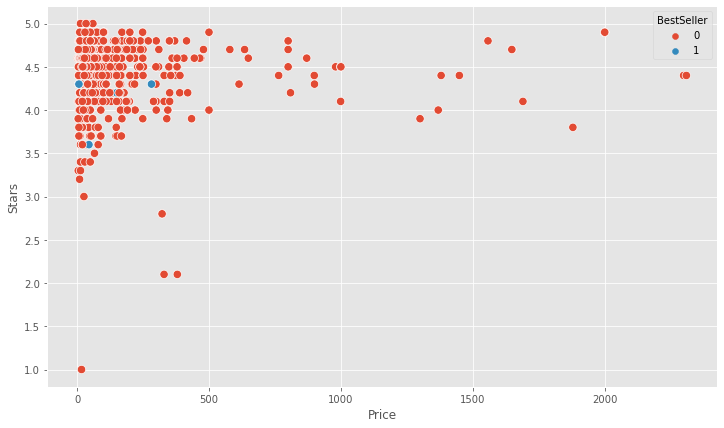

In [118]:
fig = plt.figure(figsize = (12,7))
sns.scatterplot(x = 'Price', y = 'Stars', s = 70, hue = 'BestSeller', data = df)

Here we see that if the price is low the item is most likely to be a best seller

3D scatter on Rating, Comments, Price values

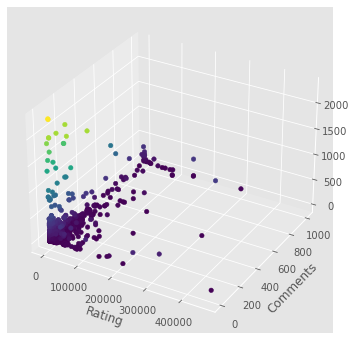

In [119]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection = '3d')

xdata = df.Rating
ydata = df.Comments
zdata = df.Price

plt.xlabel('Rating')
plt.ylabel('Comments')

ax.scatter3D(xdata,ydata,zdata,c = zdata,depthshade = False)

Pair plot for our useful fields.

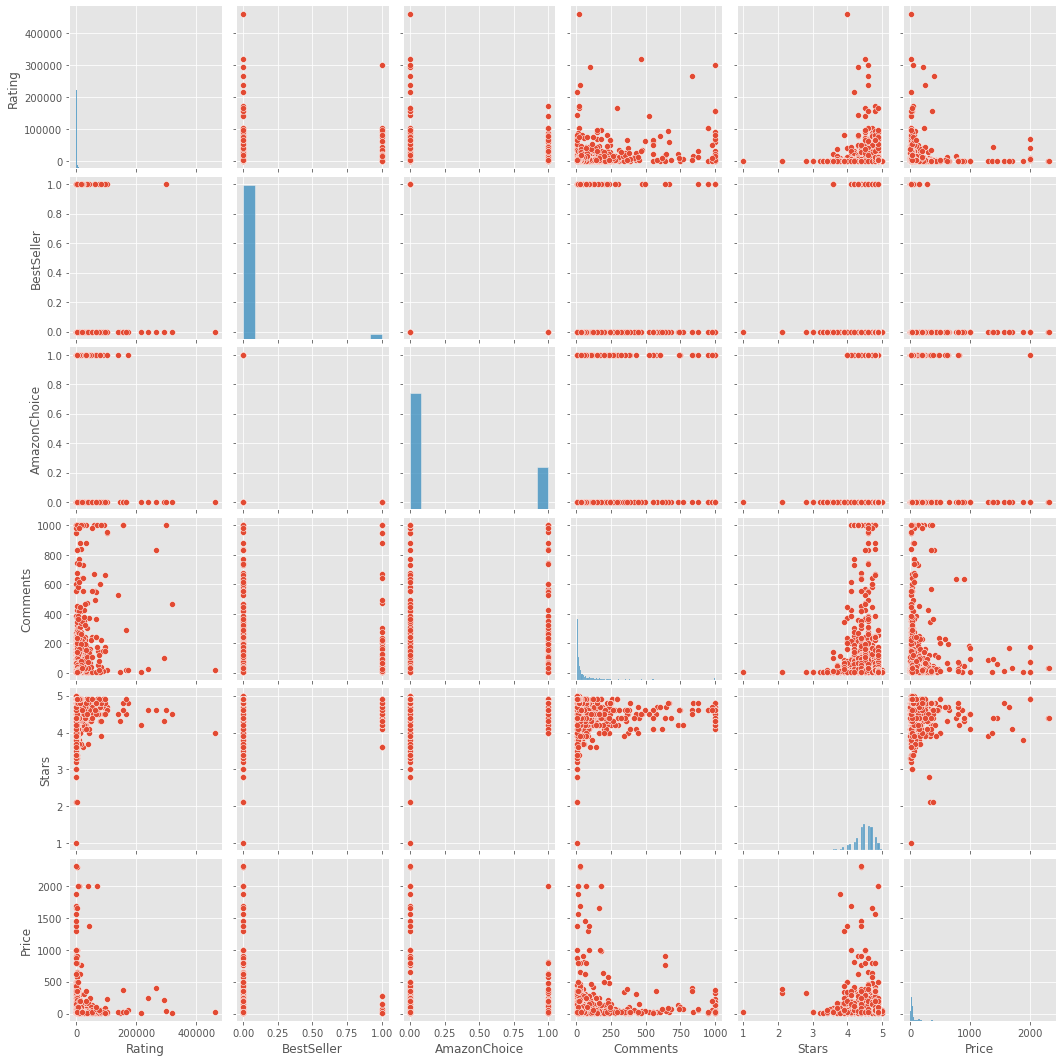

In [120]:
sns.pairplot(df[['Rating', 'BestSeller', 'AmazonChoice' ,'Comments', 'Stars', 'Price']])

# Supervised Learning 

Our approach here is to use classification by running the Logistic Regression algorithm with our BestSeller column out of the df.
1. load the data from 'Amazon Items Cleaned.csv' to a data frame.
2. Split the data to X and y where X containing all relevant features and y is our BestSeller column.
3. Split the data into train and test subsets: X_train, X_test, y_train, y_test. We will use random pick and default size of 25%.
4. Run the algorithm to train the model with fit().

In [664]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, f1_score

df1 = pd.read_csv("Amazon Items Cleaned.csv")
df1

# import matplotlib.pyplot as plt
# %matplotlib inline  
# plt.rcParams['figure.figsize'] = (10, 6)

# lrm = linear_model.LogisticRegression()
# lrm.fit(df[["Stars"]],df["BestSeller"])
# df.plot.scatter(x='Stars',y='BestSeller',s=30)
# x = np.linspace(df['Stars'].min(),df['Stars'].max(),1000)
# y_pred_p=lrm.predict_proba(np.reshape(x, (-1, 1)))
# y_pred_p1=[y[1] for y in y_pred_p]
# plt.plot(x,y_pred_p1,color='Black')
# plt.plot(x,[0.5]*len(x),color="red")
# plt.show()

,Name,Brand,Rating,BestSeller,AmazonChoice,Comments,Price,Stars
0,"NOCO NUSB211NA 10W USB Power Adapter, 2.1A 5V ...",NOCO,3869.0,0,0,28.0,13.95,4.7
1,Amazfit Band 5 Activity Fitness Tracker with A...,Amazfit,21158.0,0,0,1000.0,29.88,4.1
2,Amazon Basics Universal Travel Case Organizer ...,AmazonBasics,16242.0,0,1,277.0,14.44,4.6
3,"Amazon Glow with Tangram Bits | Learn, Play, R...",Amazon,215.0,0,1,31.0,329.98,4.4
4,"Echo Show 5 (2nd Gen, 2021 release) - Deep Sea...",Amazon,928.0,0,1,21.0,114.98,4.7
...,...,...,...,...,...,...,...,...
1631,American Eagle Gift Card,American Eagle,5999.0,0,0,4.0,25.00,4.9
1632,Amazon.com Gift Cards - As a Bookmark,Amazon,3950.0,0,0,15.0,100.00,4.9
1633,Amazon.com Gift Card in a Gift Tag,Amazon,7520.0,0,0,12.0,10.00,4.9
1634,"Amazon.com $10 Gift Cards, Pack of 3 (Holiday ...",Amazon,3014.0,0,0,3.0,30.00,4.9


Split dataset into feature vector (X) and target value (y) series

In [665]:
df = df1.copy()
X = df
y = df["BestSeller"]
X.pop("BestSeller")
X.pop("Name")
X.pop("Brand")

X


,Rating,AmazonChoice,Comments,Price,Stars
0,3869.0,0,28.0,13.95,4.7
1,21158.0,0,1000.0,29.88,4.1
2,16242.0,1,277.0,14.44,4.6
3,215.0,1,31.0,329.98,4.4
4,928.0,1,21.0,114.98,4.7
...,...,...,...,...,...
1631,5999.0,0,4.0,25.00,4.9
1632,3950.0,0,15.0,100.00,4.9
1633,7520.0,0,12.0,10.00,4.9
1634,3014.0,0,3.0,30.00,4.9


In [666]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1631    0
1632    0
1633    0
1634    0
1635    0
Name: BestSeller, Length: 1636, dtype: int64

Setting a function for splitting into train and test

In [667]:
# Function - Spliting the dataset into test and train
# test_size = default 0.25
# random_state = default np.random

def split_to_train_and_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return X_train, X_test, y_train, y_test

In [668]:
# function - MinMax Scaler

def scale_features(X_train):
    scaler = MinMaxScaler(feature_range=(0, 1)) # StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    return X_train_scaled

Logistic Regression - Evaluation using r2_score

Splitting the data into train and test subsets

In [672]:
X_train, X_test, y_train, y_test = split_to_train_and_test(X,y)

X_train


,Rating,AmazonChoice,Comments,Price,Stars
1617,6792.0,0,29.0,50.00,4.9
500,9.0,0,61.0,69.95,4.2
1514,698.0,0,23.0,57.99,4.6
1449,1942.0,0,9.0,21.99,4.5
1274,195.0,0,7.0,15.99,4.3
...,...,...,...,...,...
619,1.0,0,27.0,19.99,4.6
1272,143.0,0,17.0,19.99,3.9
977,14355.0,0,89.0,20.79,4.8
233,39.0,0,4.0,10.99,4.7


In [687]:
clf_model = LogisticRegression().fit(X_train, y_train)
clf_model
y_pred=clf_model.predict(X_test)

resDF = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
resDF.to_csv("Amazon Predict.csv", index = None)
resDF



,Actual,Predicted
58,0,0
986,1,0
384,0,0
195,0,0
440,0,0
...,...,...
428,0,0
1542,0,0
987,0,0
665,0,0


In [684]:
indexes = resDF[resDF['Predicted'] == True].index.tolist()
resDF
print('Index of predicted products: ' +
      str(resDF[resDF['Predicted'] == True].index.tolist()))
for i in indexes:
    print(X_test.loc[i])


Index of predicted products: [1021]
Rating          300021.00
AmazonChoice         0.00
Comments          1000.00
Price               40.96
Stars                4.60
Name: 1021, dtype: float64


Let's look at the actual product that was predicted to become a bestseller. ('Predicted' and 'Actual' == 1)

We can see some indication we saw before:
1. Ratings - > 100k 
2. Amazon's choice - 0 negligible.
3. Comments - negligible.
4. Price - 0-300$ like we saw in the EDA section where the majority of Bestsellers was.
5. Stars - > 4 Stars like we predicted before.

In [675]:
# Count number of predicted items

count = 0
for i in resDF["Predicted"] :
    if i == 1 :
        count = count + 1
print(count)

1


We tried to predict if an item will be a Best Seller on amazon via logistic regression.

We found a correlation between the result to the actual bestsellers characteristics, but yet a lot of other items stand in the same criteria and not predicted also.

Note: Our prediction not always gives right output.

We will try to use another Classifier - KNN

In [676]:
df

,Rating,AmazonChoice,Comments,Price,Stars
0,3869.0,0,28.0,13.95,4.7
1,21158.0,0,1000.0,29.88,4.1
2,16242.0,1,277.0,14.44,4.6
3,215.0,1,31.0,329.98,4.4
4,928.0,1,21.0,114.98,4.7
...,...,...,...,...,...
1631,5999.0,0,4.0,25.00,4.9
1632,3950.0,0,15.0,100.00,4.9
1633,7520.0,0,12.0,10.00,4.9
1634,3014.0,0,3.0,30.00,4.9


Let's run KNN to try to classify our best sellers within the items.

We'll take a look only on the Stars and Rating from features.

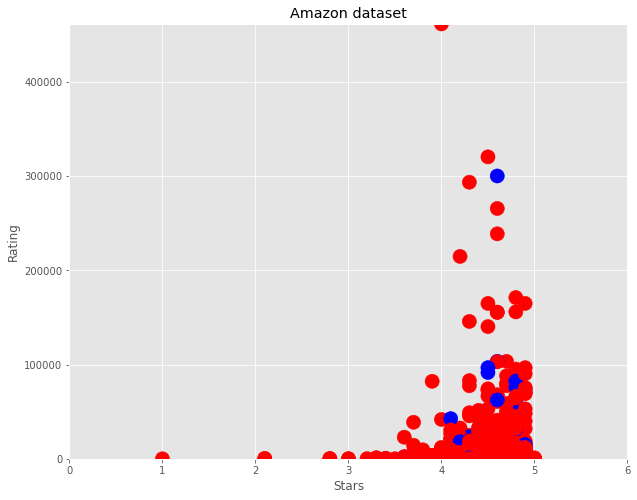

In [677]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


X = X[['Stars', 'Rating']]
# y = y

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# plot data
plt.figure(figsize=(10, 8))
plt.scatter(X.Stars, X.Rating, c=y,  marker="o", cmap=cmap_bold, s=200)


x_min, x_max = X.Stars.min() - 1, X.Stars.max() + 1
y_min, y_max = X.Rating.min() - 1, X.Rating.max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Amazon dataset')
plt.xlabel('Stars')
plt.ylabel('Rating')
plt.show()


The blue dots above uses as indicators for bestsellers.

Now let's train the KNN classifier on the train set and try to asses it's performance by printing the confusion matrix, followed by the accuracy score.

In [678]:


# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(
    X, y, random_state=1, test_size=0.2)

# set up the model, k-NN classification with k = ?
k = 3
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(XTrain, yTrain)

y_pred = clf.predict(XTest)

print(metrics.confusion_matrix(y_true=yTest, y_pred=y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))


[[317   2]
 [  9   0]]
Accuracy =  0.9664634146341463


Now we are running a test for various values of k to check which value of k (the amount of k = number of categories) gives the best result 

In [679]:
k_s = []
train_accuracies = []
test_accuracies = []
for k in range(1, 21):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(XTrain, yTrain)
    y_pred_train = clf.predict(XTrain)
    y_pred = clf.predict(XTest)
    k_s.append(k)
    train_accuracies.append(metrics.accuracy_score(
        y_true=yTrain, y_pred=y_pred_train))
    test_accuracies.append(metrics.accuracy_score(y_true=yTest, y_pred=y_pred))

df = pd.DataFrame({"k": k_s, "train_accuracy": train_accuracies,
                  "test_accuracy": test_accuracies})
df


,k,train_accuracy,test_accuracy
0,1,0.999235,0.954268
1,2,0.971713,0.972561
2,3,0.972477,0.966463
3,4,0.971713,0.972561
4,5,0.971713,0.972561
5,6,0.971713,0.972561
6,7,0.971713,0.972561
7,8,0.971713,0.972561
8,9,0.971713,0.972561
9,10,0.971713,0.972561


We found that the best k is k = 1 with accuracy score of 0.948171 which is the min.

We will create the classification visualization for the knn classifier (based on the selected k). 


c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Yaniv\AppData\Local\Temp/ipykernel_17704/2550791013.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xx, yy, zz, cmap=cmap_light)


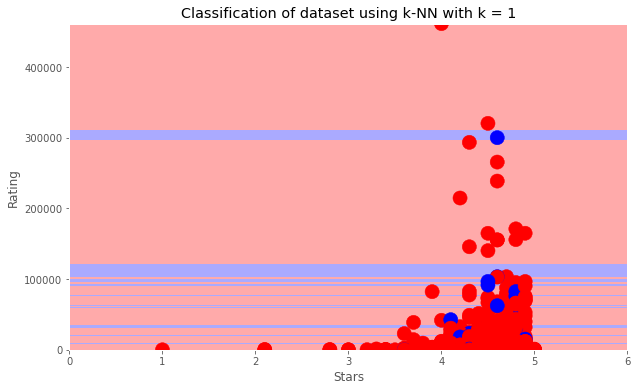

In [680]:
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X, y)

# plot classification
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, zz, cmap=cmap_light)

# plot data
plt.scatter(X.Stars, X.Rating, c=y, cmap=cmap_bold, s=200)

plt.title('Classification of dataset using k-NN with k = ' + str(k))
plt.xlabel('Stars')
plt.ylabel('Rating')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()


Cross validation to estimate the accuracy of a knn model on the dataset : checking for better k.
1. Splitting the data
2. fitting a model and computing the score 10 consecutive times with different splits each time
3. printing overall score for the model.

In [681]:
clf = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(clf, X, y, cv=10)

scores


array([0.9695122 , 0.9695122 , 0.9695122 , 0.9695122 , 0.9695122 ,
       0.9695122 , 0.97546012, 0.97546012, 0.97546012, 0.97546012])

In [682]:

print("Overall accuracy: %0.2f" % scores.mean())


Overall accuracy: 0.97


In [683]:
clf = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(clf, X, y, cv=10)
scores_list=[cross_val_score(clf, X, y, cv=flds).mean() for flds in range(3,26)]
print("highest result with X-fold, x=",np.argmax(scores_list)+3)

highest result with X-fold, x= 25


GridSearchCV
We use the scoring parameter in order to define which evaluation score to optimize.

In [650]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {'n_neighbors': range(1, 25, 2)}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, scoring=make_scorer(
    metrics.accuracy_score, greater_is_better=True))
clf.fit(XTrain, yTrain)

print("best parameter set is:", clf.best_params_,
      " and its score was", clf.best_score_)

#if you want to see all iterations internal numbers uncomment the next line
#print(clf.cv_results_.items())


best parameter set is: {'n_neighbors': 5}  and its score was 0.9717147787429441


# Unsupervised Learning

In [651]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import sklearn
from sklearn import cluster

from sklearn import metrics, preprocessing, neighbors, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')
# Create color maps
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

df = pd.read_csv("Amazon Items Cleaned.csv")
df

,Name,Brand,Rating,BestSeller,AmazonChoice,Comments,Price,Stars
0,"NOCO NUSB211NA 10W USB Power Adapter, 2.1A 5V ...",NOCO,3869.0,0,0,28.0,13.95,4.7
1,Amazfit Band 5 Activity Fitness Tracker with A...,Amazfit,21158.0,0,0,1000.0,29.88,4.1
2,Amazon Basics Universal Travel Case Organizer ...,AmazonBasics,16242.0,0,1,277.0,14.44,4.6
3,"Amazon Glow with Tangram Bits | Learn, Play, R...",Amazon,215.0,0,1,31.0,329.98,4.4
4,"Echo Show 5 (2nd Gen, 2021 release) - Deep Sea...",Amazon,928.0,0,1,21.0,114.98,4.7
...,...,...,...,...,...,...,...,...
1631,American Eagle Gift Card,American Eagle,5999.0,0,0,4.0,25.00,4.9
1632,Amazon.com Gift Cards - As a Bookmark,Amazon,3950.0,0,0,15.0,100.00,4.9
1633,Amazon.com Gift Card in a Gift Tag,Amazon,7520.0,0,0,12.0,10.00,4.9
1634,"Amazon.com $10 Gift Cards, Pack of 3 (Holiday ...",Amazon,3014.0,0,0,3.0,30.00,4.9


Transfering DataFrame to numeric values

Let's transfer the Name and Brand columns to a numeric value# Transfering DataFrame to numeric values

In [652]:
def transfer_str_to_numeric_vals(dataset,str_col,id_col_to_remove):
    DF = dataset.copy()
    for column in DF :
        DF[str_col] = pd.factorize(DF[str_col])[0] + 1
    DF.pop(id_col_to_remove)
    return DF

num_dataset = transfer_str_to_numeric_vals(df, 'Name', 'Brand')
num_dataset

,Name,Rating,BestSeller,AmazonChoice,Comments,Price,Stars
0,1,3869.0,0,0,28.0,13.95,4.7
1,2,21158.0,0,0,1000.0,29.88,4.1
2,3,16242.0,0,1,277.0,14.44,4.6
3,4,215.0,0,1,31.0,329.98,4.4
4,5,928.0,0,1,21.0,114.98,4.7
...,...,...,...,...,...,...,...
1631,660,5999.0,0,0,4.0,25.00,4.9
1632,1439,3950.0,0,0,15.0,100.00,4.9
1633,1440,7520.0,0,0,12.0,10.00,4.9
1634,1441,3014.0,0,0,3.0,30.00,4.9


Scaling DataSet

Using standard scaler to scale the dataset

In [653]:
def scale_dataset(dataset):
    scaler = StandardScaler()
    
    DFScaled = scaler.fit_transform(dataset)
    
    return DFScaled

dfScaled = scale_dataset(num_dataset)
dfScaled

array([[-1.59221768, -0.12708992, -0.17009062, ..., -0.27852636,
        -0.33342472,  0.74935901],
       [-1.5898465 ,  0.53877864, -0.17009062, ...,  5.62962395,
        -0.2580302 , -1.19299854],
       [-1.58747532,  0.34944381, -0.17009062, ...,  1.23498128,
        -0.33110562,  0.42563275],
       ...,
       [ 1.81990883,  0.0135247 , -0.17009062, ..., -0.37577987,
        -0.35211953,  1.39681153],
       [ 1.82228001, -0.16001939, -0.17009062, ..., -0.43048496,
        -0.25746226,  1.39681153],
       [ 1.82465119,  0.40582831, -0.17009062, ..., -0.24813464,
        -0.26692798,  0.42563275]])

Check vie K-means data division into 7 clusters in 1 iteration

7 beacause we have 7 columns

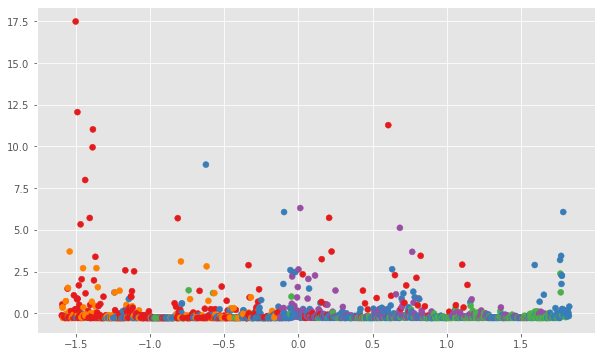

In [654]:
model = KMeans(n_clusters=5, n_init=1, init='random', max_iter=1)
y_pred = model.fit_predict(dfScaled)
plt.scatter(dfScaled[:, 0], dfScaled[:, 1], c=y_pred,  marker="o", cmap=cmap);

Thanks to K-means visualization we can already see that our data cannot be divided into clusters.

Amazon's data cannot tell the difference between items and to badge them into a cluster.
We already saw in our Supervise Learning that the computer can't find correlation between columns and answer our research question
that is why also with UnSupervised Learning the computer can't divide the data into visual different clusters

 But, we will continue to write our code and still try to divide the data to clusters and maybe we will find our answer

 First, let's find the right number of clusters
K-means

In [655]:
def perform_k_means(dataset, num_clusters, init_val, n_init_val, rand_state):
    model = KMeans(n_clusters = num_clusters, n_init = n_init_val, init = init_val, random_state = rand_state)
    predicted_vals = model.fit_predict(dataset)
        
    return model, predicted_vals

Find best initialization parameters for K-means

In [656]:
def get_best_init_params_for_k_means(dataset, num_clusters, init_options, n_init_options, rand_state):
    
    score_list = list()
            
    for i in n_init_options :
        for j in init_options :
            Kresult = perform_k_means(dataset, num_clusters, j, i,rand_state)
            score_list.append(Kresult[0].inertia_)
        print(Kresult)
    
    best_score = score_list[0]
    
    for i in range(0,len(score_list),1) :
        if score_list[i] < best_score :
            best_score = score_list[i]
            best_init_val = Kresult[0].init
            best_n_init_val = Kresult[0].n_init            
    
    return best_score, best_init_val, best_n_init_val

num_clusters = 3
init_options = ['random', 'k-means++']
n_init_options = [1,5,10]
rand_state = 42

best_score, best_init_val, best_n_init_val = get_best_init_params_for_k_means(dfScaled, num_clusters, init_options, n_init_options, rand_state)    
print(best_score)
print(best_init_val)
print(best_n_init_val)

(KMeans(n_clusters=3, n_init=1, random_state=42), array([0, 0, 1, ..., 0, 0, 0]))
(KMeans(n_clusters=3, n_init=5, random_state=42), array([0, 0, 1, ..., 0, 0, 0]))
(KMeans(n_clusters=3, random_state=42), array([0, 0, 1, ..., 0, 0, 0]))
8015.931546209357
k-means++
10


In [657]:
def compare_number_of_clusters(dataset, num_cluster_options, init_val, n_init_val, rand_state):

    lst_scores = list()
            
    for i in num_cluster_options :
        Kresult = perform_k_means(dataset, i, init_val, n_init_val, rand_state)
        lst_scores.append(Kresult[0].inertia_)
            
    return lst_scores

num_clusters_options = [1,2,3,4,5,6,7,8,9]
init_val = 'k-means++'
n_init_val = 10
rand_state = 42

scores = compare_number_of_clusters(dfScaled, num_clusters_options, init_val, n_init_val, rand_state)
scores

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[11452.0,
 9663.940596011536,
 8015.931546209357,
 6843.999726735043,
 5608.589002664361,
 4886.986335704819,
 4037.563070597593,
 3434.466154971799,
 3142.615343260596]

c:\Users\Yaniv\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


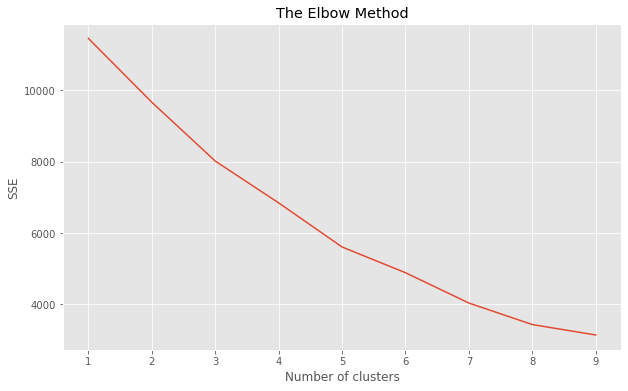

In [658]:
scores_2_3 = compare_number_of_clusters(dfScaled, num_clusters_options, init_val, n_init_val, rand_state)

plt.plot(num_clusters_options,scores_2_3)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

With the elbow method we can see that the best number of clusters is 8

Evaluation of K-means with silhouette score

In [659]:
def get_best_num_of_clusters_for_k_means(dataset, num_cluster_options, init_val, n_init_val, rand_state):
    
    lst_scores = list()
    silhouette_lst = list()
    Klist = list()
            
    for i in num_cluster_options :
        Kresult = perform_k_means(dataset, i, init_val, n_init_val, rand_state)
        Klist.append(Kresult[0].n_clusters)
        lst_scores.append(Kresult[1])
        
    best_score = silhouette_score(dataset, lst_scores[0])
        
    for i in range(0,len(lst_scores),1) :
        if silhouette_score(dataset, lst_scores[i]) > best_score :
            best_score = silhouette_score(dataset, lst_scores[i])
            num_clusters = Klist[i]
        
    return best_score, num_clusters

num_clusters_options = [2,3,4,5,6,7,8,9]
init_val = 'k-means++'
n_init_val = 1
rand_state = 42

best_score, best_num_clusters = get_best_num_of_clusters_for_k_means(dfScaled, num_clusters_options, init_val, n_init_val, rand_state)
print("Best number of clusters is : " + str(best_num_clusters))
print("The best score is : " + str(best_score))


Best number of clusters is : 8
The best score is : 0.34672514888171496


A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters

Best silhouette score is 0.3

0.3 score means that clusters are overlapping

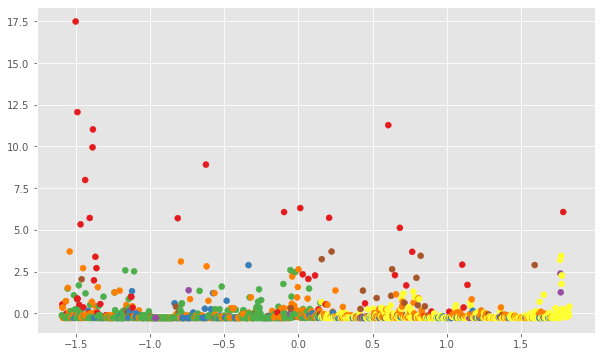

In [660]:
km = KMeans(n_clusters=8, n_init=10, init='random', max_iter=10)
y_pred = km.fit_predict(dfScaled)
plt.scatter(dfScaled[:, 0], dfScaled[:, 1], c=y_pred,  marker="o", cmap=cmap);

Continue trying this time with hierarchical clustering

In [661]:
def perform_hierarchical_clustering(dataset, num_clusters, linkage_val):
    
    agg_cluster_model = AgglomerativeClustering(n_clusters = num_clusters, linkage = linkage_val)
    y_pred = agg_cluster_model.fit_predict(dataset)
    
    return agg_cluster_model, y_pred

linkage_val = 'single'
hierarchical_model, predicted_vals = perform_hierarchical_clustering(dfScaled, num_clusters, linkage_val)
print(hierarchical_model)
print(predicted_vals)

AgglomerativeClustering(linkage='single', n_clusters=3)
[0 0 0 ... 0 0 0]


Find best 'linkage' method for hierarchical agglomerative clustering

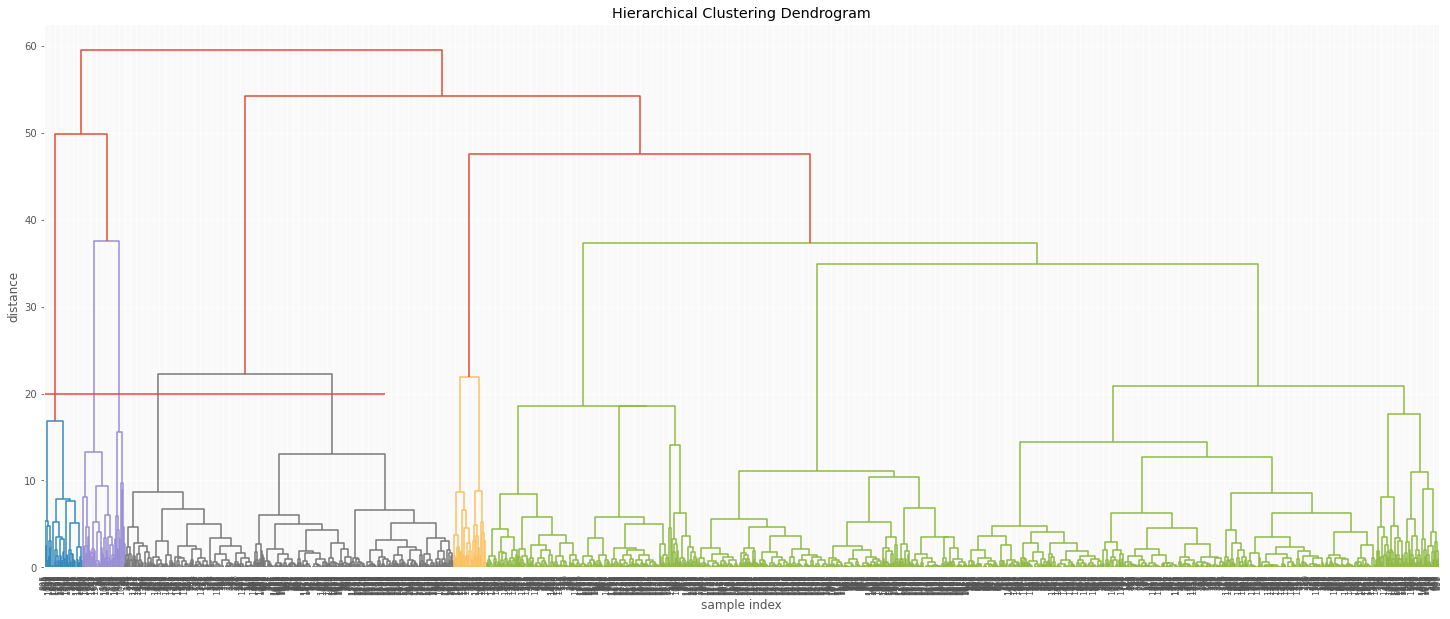

In [685]:
Z = linkage(dfScaled, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z,
           leaf_rotation=90.,
           leaf_font_size=8.,
           )
plt.hlines(20, 0, 4000)
plt.show()


We can see in the dendogram, that while at the bottom all linkages are very short, there are much more distant linkages higher up. Therefore we draw a line at the area where it seems logical to split the clusters

According to this line we get 10 clusters.

Find best 'linkage' method for hierarchical agglomerative clustering

In [662]:
def get_best_linkage_method(dataset, num_clusters, linkage_options):
    
    Kresult = list()
    Klist = list()
    lst_scores = list()
    
    for i in linkage_options :
        Kresult = perform_hierarchical_clustering(dataset, num_clusters, i)
        lst_scores.append(Kresult[1])
        Klist.append(Kresult[0].linkage)
                        
    best_score = silhouette_score(dataset, lst_scores[0])
        
    for i in range(0,len(lst_scores),1) :
        if silhouette_score(dataset, lst_scores[i]) > best_score :
            best_score = silhouette_score(dataset, lst_scores[i])
            best_linkage = Klist[i]
        
    return best_score, best_linkage

num_clusters = 8
linkage_options = ['single', 'complete', 'average', 'ward']
rand_state = 42

best_score, best_linkage_method = get_best_linkage_method(dfScaled, num_clusters, linkage_options)
print(best_score)
print(best_linkage_method)

0.5800603058478546
average


We can see that our silhouette score has gone up but stiil not good enough

Means that clusters are overlapping

DBSCAN

In [663]:
def perform_density_based_clustering(dataset, epsilon_val, minimum_samples_val):
    model = DBSCAN(eps = epsilon_val, min_samples = minimum_samples_val)
    predicted_vals = model.fit_predict(dataset)
    
    return model, predicted_vals

epsilon_val = 10
minimum_samples_val = 5
density_based_model, predicted_vals = perform_density_based_clustering(num_dataset, epsilon_val, minimum_samples_val)
print(density_based_model)
print(predicted_vals)

DBSCAN(eps=10)
[-1 -1 -1 ... -1 -1 -1]


In [ ]:
db_model = DBSCAN(eps=1.5, min_samples=5)
db_model.fit(dfScaled)
y_pred = db_model.fit_predict(dfScaled)

plt.scatter(dfScaled[:, 0], dfScaled[:, 1], c=y_pred,  marker="o", cmap=cmap)


Also, via DBSCAN we cannot determine our research question

In conclusion:

After using Both Supervised and UnSupervised Learning we can conclude that we can't really find out what makes an item a BestSeller for sure.
We tried to predict a bestseller using classification, we've got a right prediction but we can't really find it exact every time.
Using KNN was not so helpful also, we tried to figure what k as number of classes we got best score for k=1.
We also tried split the items into different groups using the unsupervised methods and didn't really find good results.

We think that we need more information in order to find better results.

Written by:
Yaniv Lavi and Stas Bratanich

Data Science Course - Final Project

Holon Institute Of Technology